In [1]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 4
DATA_LENGTH = 1000
EPOCH = 100

REF_H, REF_W = 768, 1024

AIM_RES = 512

IMAGE_PATH = 'E:\\dataset\\completed\\mixed\\'
MASK_PATH = 'E:\\dataset\\completed\\mask\\'
PEOPLE_PATH = 'E:\\dataset\\completed\\people\\'
BACKGROUND_PATH = 'E:\\dataset\\completed\\background\\'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_path, mask_path, transform = None ):
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = transform
    
    def __getitem__(self, idx):
        image = cv2.resize(cv2.imread(self.image_path[idx], cv2.IMREAD_GRAYSCALE), dsize = (AIM_RES, AIM_RES)).astype(np.float32) / 255.0 # 추후에 수정해볼 만한 곳
        mask = cv2.resize(cv2.imread(self.mask_path[idx], cv2.IMREAD_GRAYSCALE), dsize = (AIM_RES, AIM_RES)).astype(np.float32) / 255.0 # 추후에 수정해볼 만한 곳
        image = torch.tensor(image.reshape(-1, AIM_RES, AIM_RES))
        mask = torch.tensor(mask.reshape(-1, AIM_RES, AIM_RES))
        
        random_seed = np.random.randint(-99999, 99999)
        
        if self.transform:
            torch.manual_seed(random_seed)
            image = self.transform(image)
            torch.manual_seed(random_seed)
            mask = self.transform(mask)
                    
        return image, mask
    
    def __len__(self):
        return len(self.image_path)

In [4]:
train_image = np.array(sorted(glob(IMAGE_PATH + '*')))[:DATA_LENGTH]
train_mask = np.array(sorted(glob(MASK_PATH + '*')))[:DATA_LENGTH]

train_image[:5], train_mask[:5]

(array(['E:\\dataset\\completed\\mixed\\0_0_mixed.png',
        'E:\\dataset\\completed\\mixed\\1000_0_mixed.png',
        'E:\\dataset\\completed\\mixed\\1001_0_mixed.png',
        'E:\\dataset\\completed\\mixed\\1002_0_mixed.png',
        'E:\\dataset\\completed\\mixed\\1003_0_mixed.png'], dtype='<U43'),
 array(['E:\\dataset\\completed\\mask\\0_0_mask.png',
        'E:\\dataset\\completed\\mask\\1000_0_mask.png',
        'E:\\dataset\\completed\\mask\\1001_0_mask.png',
        'E:\\dataset\\completed\\mask\\1002_0_mask.png',
        'E:\\dataset\\completed\\mask\\1003_0_mask.png'], dtype='<U41'))

In [5]:
image_train, image_test, mask_train, mask_test = train_test_split(train_image, train_mask, test_size = 0.2, random_state = 7, shuffle = True)
image_train.shape, mask_train.shape, image_test.shape, mask_test.shape

((800,), (800,), (200,), (200,))

In [6]:
image_train, image_valid, mask_train, mask_valid = train_test_split(image_train, mask_train, test_size = 0.3, random_state = 77, shuffle = True)
image_train.shape, mask_train.shape, image_valid.shape, mask_valid.shape

((560,), (560,), (240,), (240,))

In [7]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(AIM_RES, scale = (0.85, 1.25)),
    transforms.RandomHorizontalFlip(),
])

In [8]:
train_dataset = CustomDataset(image_train, mask_train, transform)
valid_dataset = CustomDataset(image_valid, mask_valid, transform)

In [9]:
train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)

C:\Users\user\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


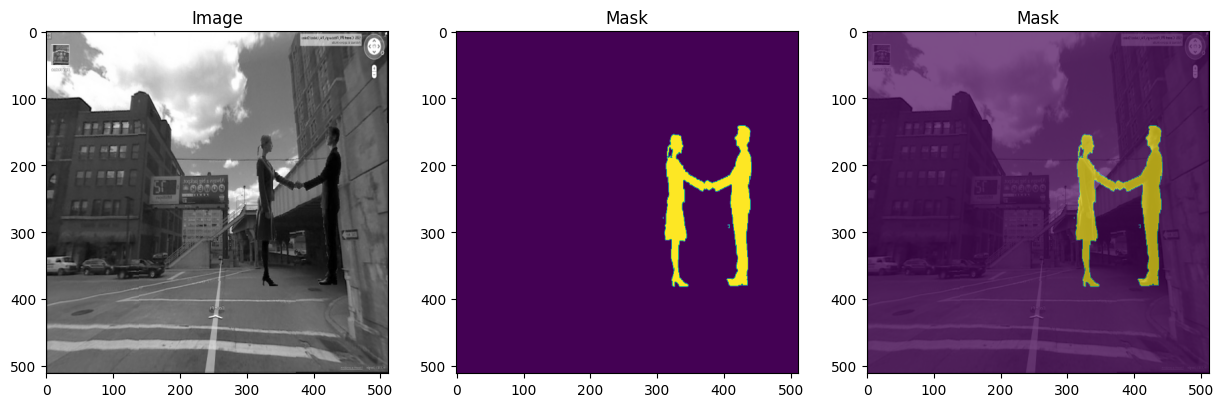

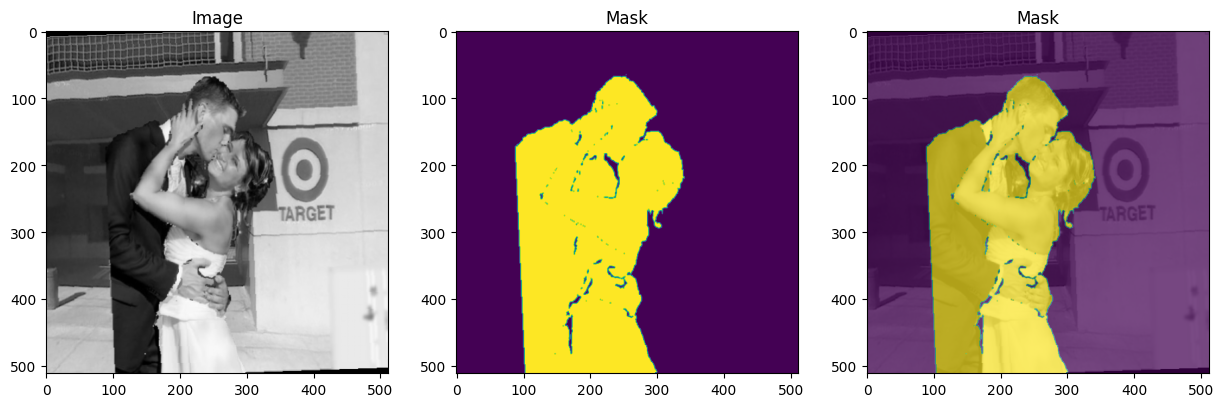

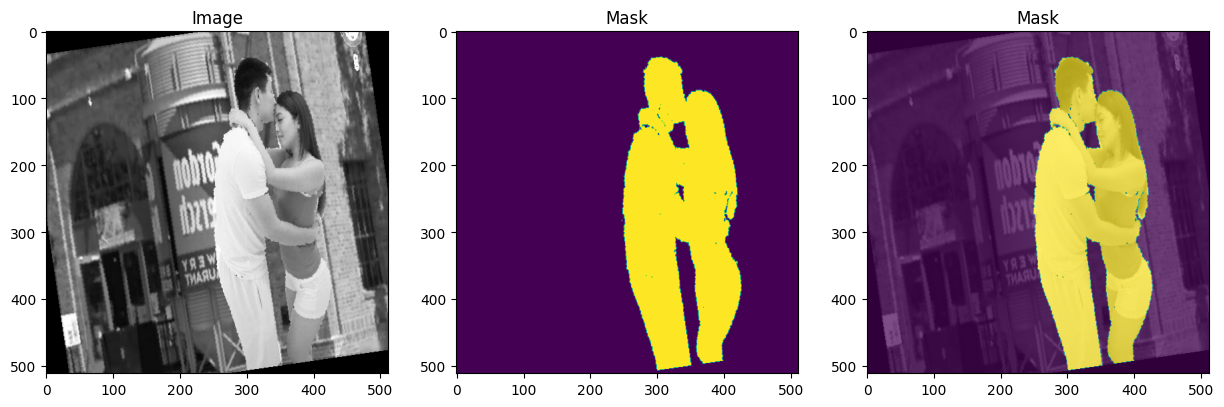

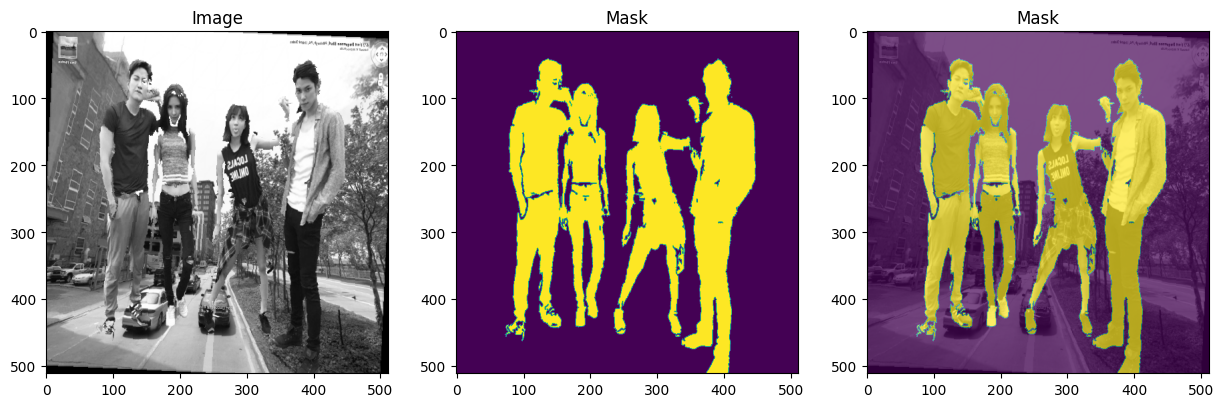

In [10]:
image, mask = next(iter(train_loader))
# image = image.numpy().reshape(-1, REF_H, REF_W, 3)
# mask = mask.numpy().reshape(-1, REF_H, REF_W, 1)

image = image.numpy().reshape(-1, AIM_RES, AIM_RES, 1)
mask = mask.numpy().reshape(-1, AIM_RES, AIM_RES, 1)

for i in range(BATCH_SIZE):
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB))
    plt.title('Image')
    plt.subplot(1, 3, 2)
    plt.imshow(mask[i])
    plt.title('Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB))
    plt.imshow(mask[i], alpha = 0.7)
    plt.title('Mask')
    plt.show()

In [11]:
def conv_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(0.2, inplace = True)
    )
    return model

def conv_transpose_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(0.2, inplace = True)
    )
    return model

def conv_block_2(in_dim, out_dim):
    model = nn.Sequential(
        conv_block(in_dim, out_dim),
        nn.Conv2d(out_dim, out_dim, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(out_dim)
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    return pool

class UNet(nn.Module):
    def __init__(self, depth, in_dim, out_dim, num_filter, diff):
        super(UNet, self).__init__()
        self.depth = depth
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        self.diff = diff

        self.down_1 = conv_block_2(self.in_dim, self.num_filter)
        self.down_2 = conv_block_2(self.num_filter, self.num_filter * 2)
        self.down_3 = conv_block_2(self.num_filter * 2, self.num_filter * 4)
        self.down_4 = conv_block_2(self.num_filter * 4, self.num_filter * 8)
        self.pool_1 = maxpool()
        self.pool_2 = maxpool()
        self.pool_3 = maxpool()
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter * 8, self.num_filter * 16)

        self.trans_1 = conv_transpose_block(self.num_filter * 16, self.num_filter * 8) 
        self.up_1 = conv_block_2(self.num_filter * 16, self.num_filter * 8)
        self.trans_2 = conv_transpose_block(self.num_filter * 8, self.num_filter * 4)
        self.up_2 = conv_block_2(self.num_filter * 8, self.num_filter * 4)
        self.trans_3 = conv_transpose_block(self.num_filter * 4, self.num_filter * 2)
        self.up_3 = conv_block_2(self.num_filter * 4, self.num_filter * 2)
        self.trans_4 = conv_transpose_block(self.num_filter * 2, self.num_filter * 1)
        self.up_4 = conv_block_2(self.num_filter * 2, self.num_filter * 1)

        self.out = nn.Conv2d(self.num_filter, self.out_dim, 3, 1, 1)
        self.sigmoid = nn.Sigmoid()
        print(f'Successfully Initialized UNet!')

    def forward(self, x):
        down_1 = self.down_1(x) # Skip Connect
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1) # Skip Connect
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2) # Skip Connect
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3) # Skip Connect
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)

        # print(f'down_4: {down_4.shape}\ntrans_1: {trans_1.shape}')

        up_1 = self.up_1(torch.cat([trans_1, down_4], dim = 1)) # Skip Connection
        trans_2 = self.trans_2(up_1)
        up_2 = self.up_2(torch.cat([trans_2, down_3], dim = 1)) # Skip Connection
        trans_3 = self.trans_3(up_2)
        up_3 = self.up_3(torch.cat([trans_3, down_2], dim = 1)) # Skip Connection
        trans_4 = self.trans_4(up_3)
        up_4 = self.up_4(torch.cat([trans_4, down_1], dim = 1)) # Skip Connection

        out = self.sigmoid(self.out(up_4))
        return out

In [12]:
# model = build_unet().to(device)
model = UNet(None, 1, 1, 16, None).to(device)
summary(model, (1, AIM_RES, AIM_RES), batch_size = BATCH_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss().to(device)

Successfully Initialized UNet!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 16, 512, 512]             160
       BatchNorm2d-2          [4, 16, 512, 512]              32
         LeakyReLU-3          [4, 16, 512, 512]               0
            Conv2d-4          [4, 16, 512, 512]           2,320
       BatchNorm2d-5          [4, 16, 512, 512]              32
         MaxPool2d-6          [4, 16, 256, 256]               0
            Conv2d-7          [4, 32, 256, 256]           4,640
       BatchNorm2d-8          [4, 32, 256, 256]              64
         LeakyReLU-9          [4, 32, 256, 256]               0
           Conv2d-10          [4, 32, 256, 256]           9,248
      BatchNorm2d-11          [4, 32, 256, 256]              64
        MaxPool2d-12          [4, 32, 128, 128]               0
           Conv2d-13          [4, 64, 128, 128]          18,496
      Ba

Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! inf -> 0.691120461622874


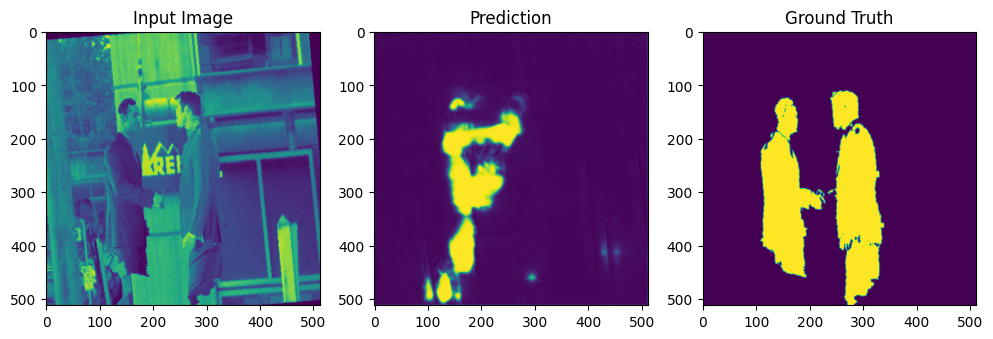

Epoch 0
=--------------------------------=
Train Loss: 0.7388461768627167, Validation Loss: 0.691120461622874
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.691120461622874 -> 0.6805457880099615


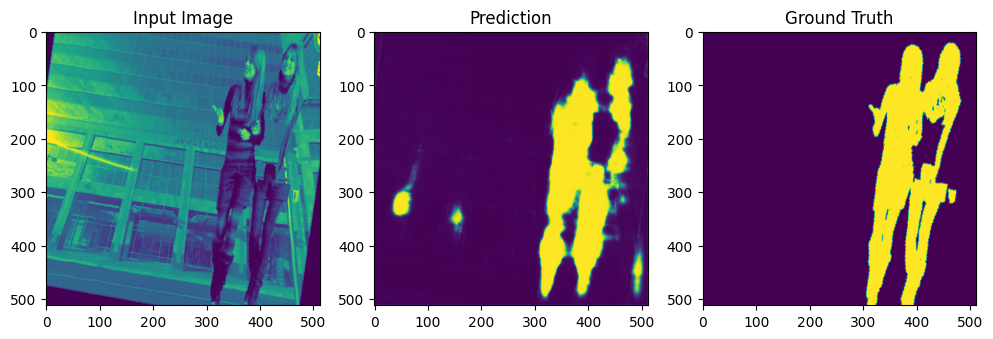

Epoch 1
=--------------------------------=
Train Loss: 0.6818215646914073, Validation Loss: 0.6805457880099615
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

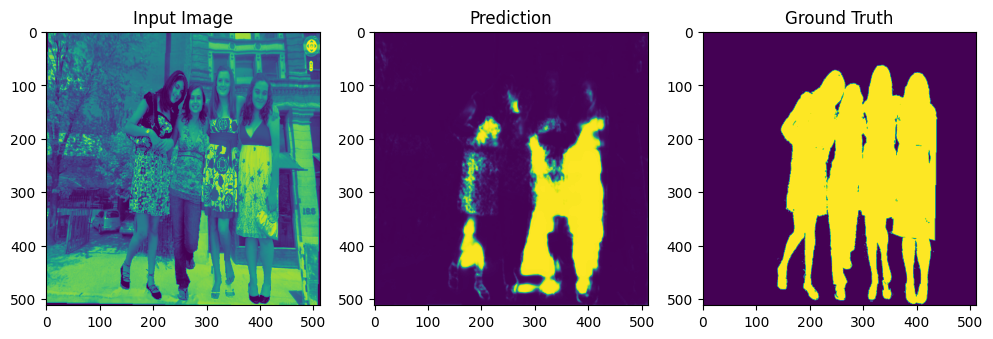

Epoch 2
=--------------------------------=
Train Loss: 0.6710819678647177, Validation Loss: 0.6838917851448059
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.6805457880099615 -> 0.6644110371669133


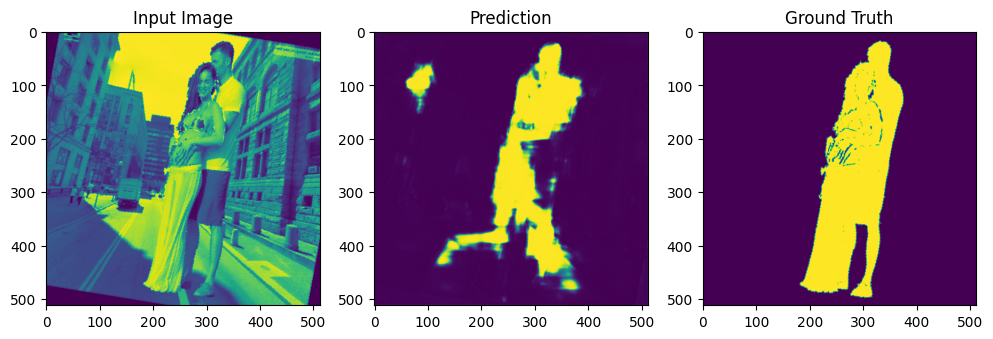

Epoch 3
=--------------------------------=
Train Loss: 0.6631203753607614, Validation Loss: 0.6644110371669133
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.6644110371669133 -> 0.6594023406505585


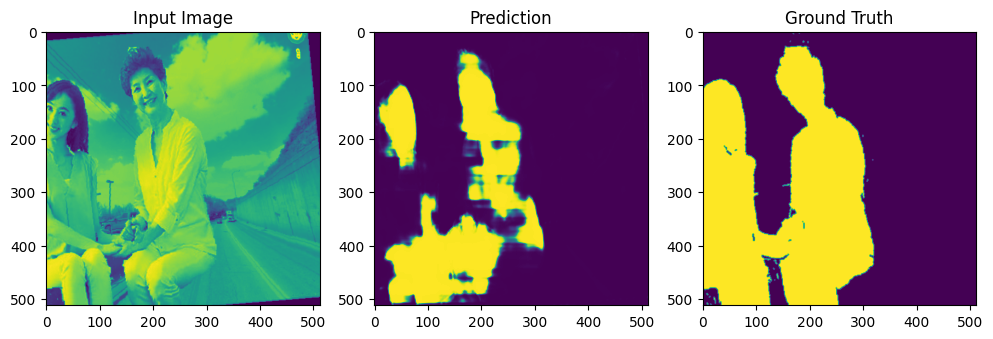

Epoch 4
=--------------------------------=
Train Loss: 0.6590962107692446, Validation Loss: 0.6594023406505585
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.6594023406505585 -> 0.6540443271398544


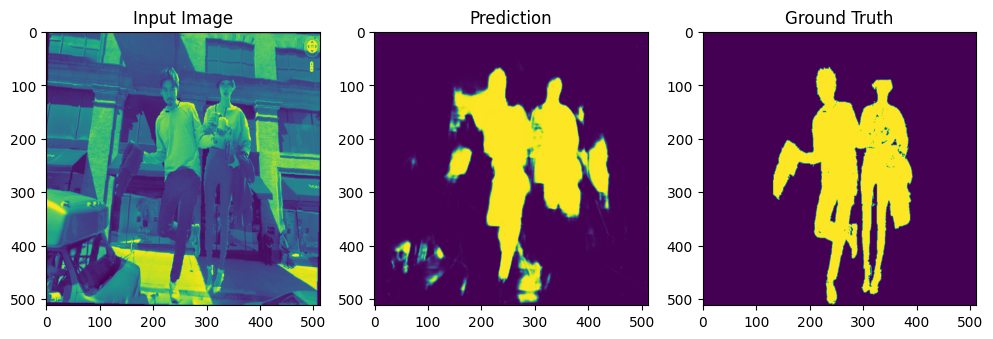

Epoch 5
=--------------------------------=
Train Loss: 0.6552504552262169, Validation Loss: 0.6540443271398544
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.6540443271398544 -> 0.6522973318894704


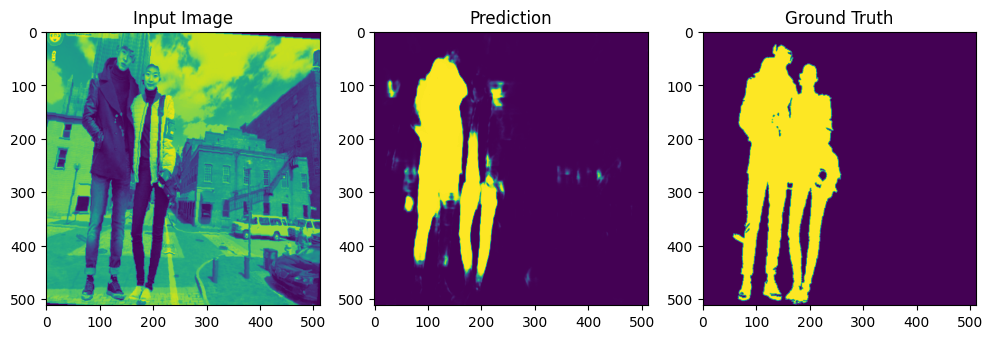

Epoch 6
=--------------------------------=
Train Loss: 0.6507791864020483, Validation Loss: 0.6522973318894704
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

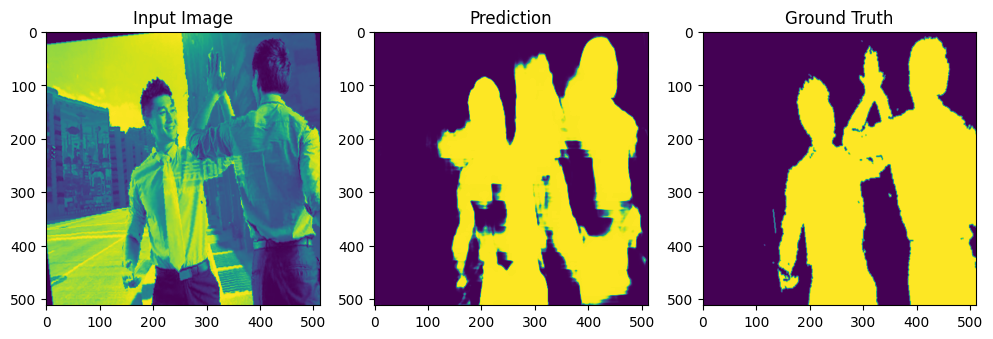

Epoch 7
=--------------------------------=
Train Loss: 0.648771859066827, Validation Loss: 0.6815993428230286
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

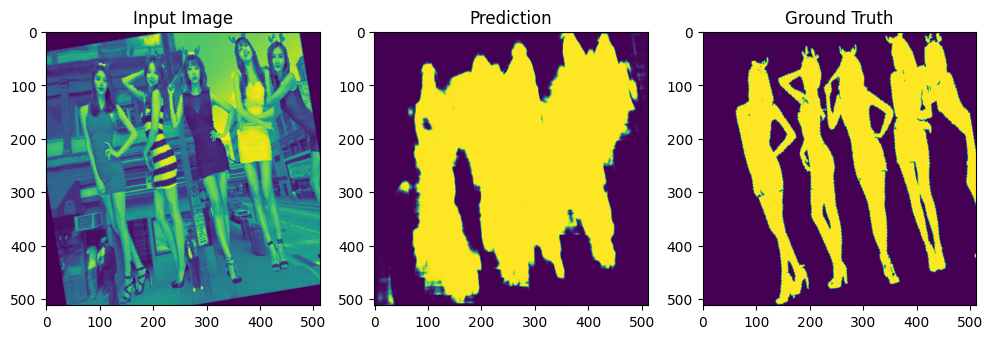

Epoch 8
=--------------------------------=
Train Loss: 0.6428001825298582, Validation Loss: 0.6566557308038076
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

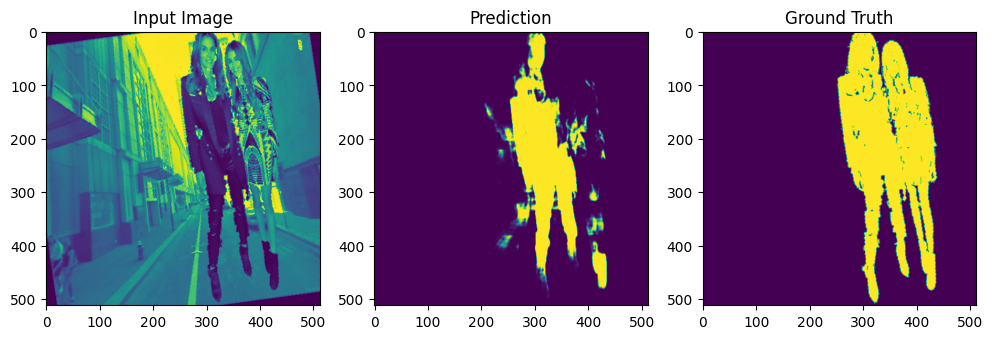

Epoch 9
=--------------------------------=
Train Loss: 0.6435750663280487, Validation Loss: 0.6560162752866745
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.6522973318894704 -> 0.639164553085963


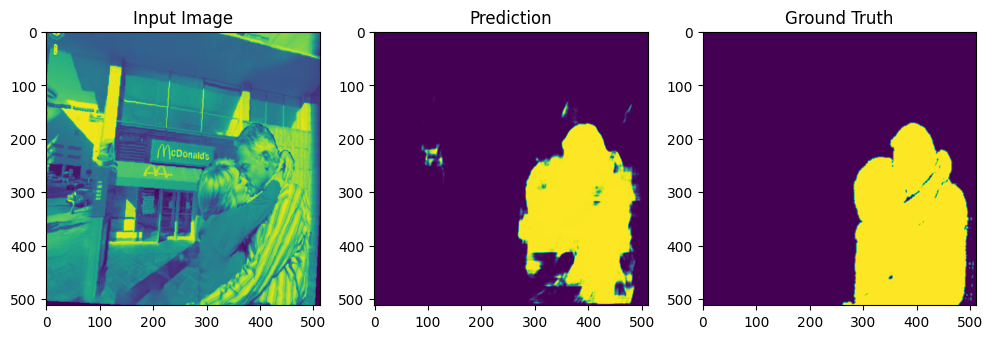

Epoch 10
=--------------------------------=
Train Loss: 0.6398922630718776, Validation Loss: 0.639164553085963
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

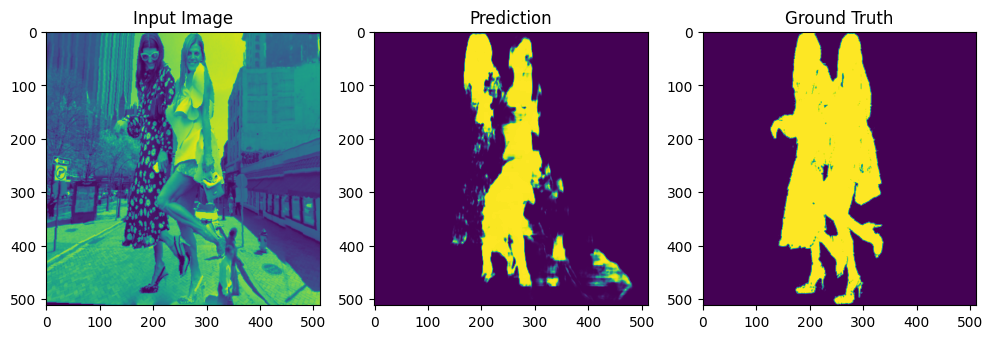

Epoch 11
=--------------------------------=
Train Loss: 0.639616390636989, Validation Loss: 0.6393757462501526
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

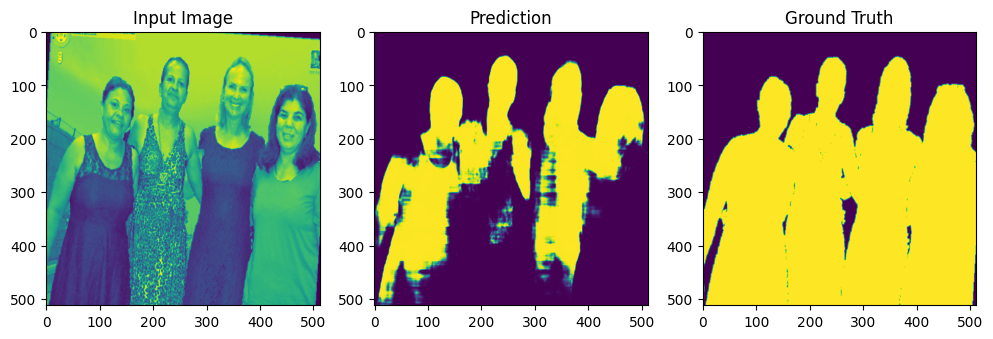

Epoch 12
=--------------------------------=
Train Loss: 0.6345376551151276, Validation Loss: 0.6471051802237828
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.639164553085963 -> 0.6373565296332041


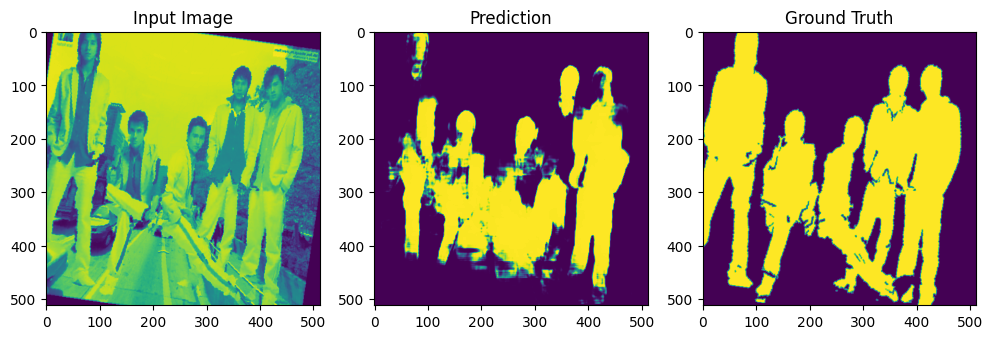

Epoch 13
=--------------------------------=
Train Loss: 0.634659600683621, Validation Loss: 0.6373565296332041
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

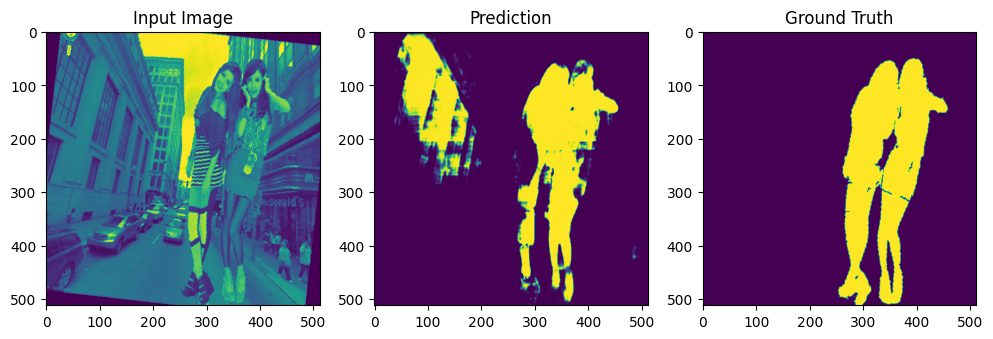

Epoch 14
=--------------------------------=
Train Loss: 0.6339404425450734, Validation Loss: 0.6624359538157781
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

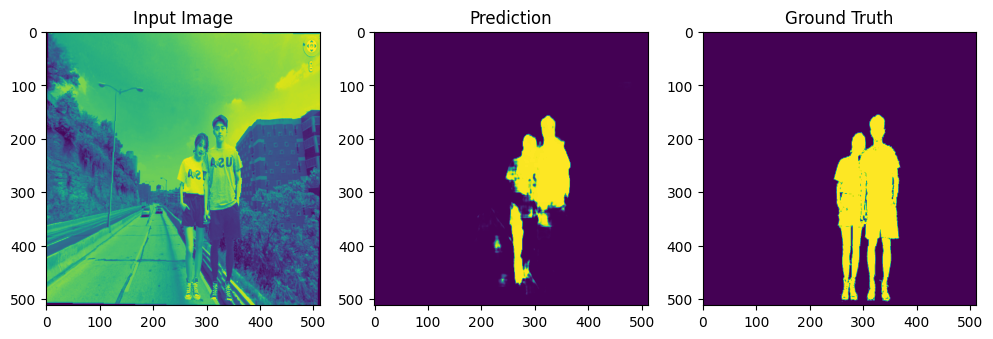

Epoch 15
=--------------------------------=
Train Loss: 0.6333182007074356, Validation Loss: 0.6423623601595561
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.6373565296332041 -> 0.6349300613005956


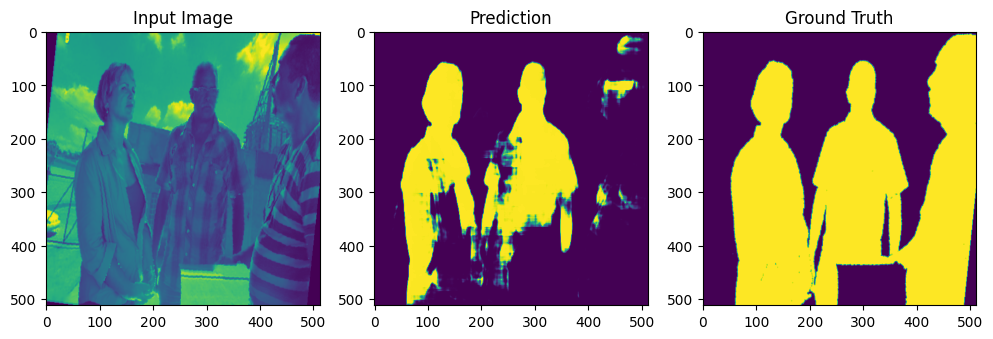

Epoch 16
=--------------------------------=
Train Loss: 0.629368525317737, Validation Loss: 0.6349300613005956
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.6349300613005956 -> 0.6319201707839965


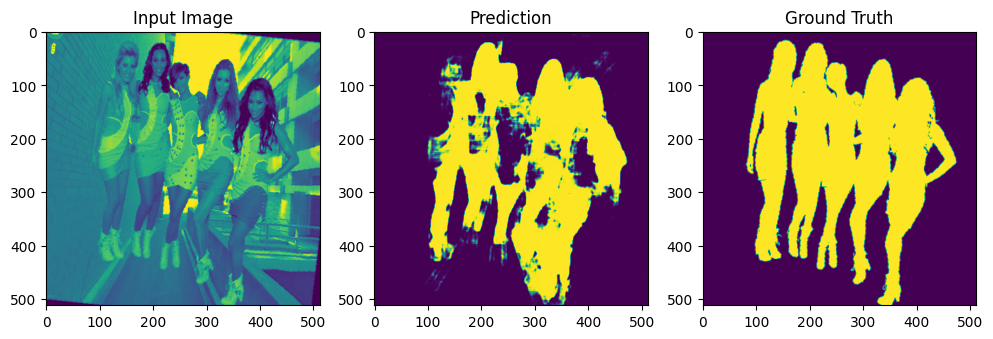

Epoch 17
=--------------------------------=
Train Loss: 0.6257769508021218, Validation Loss: 0.6319201707839965
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

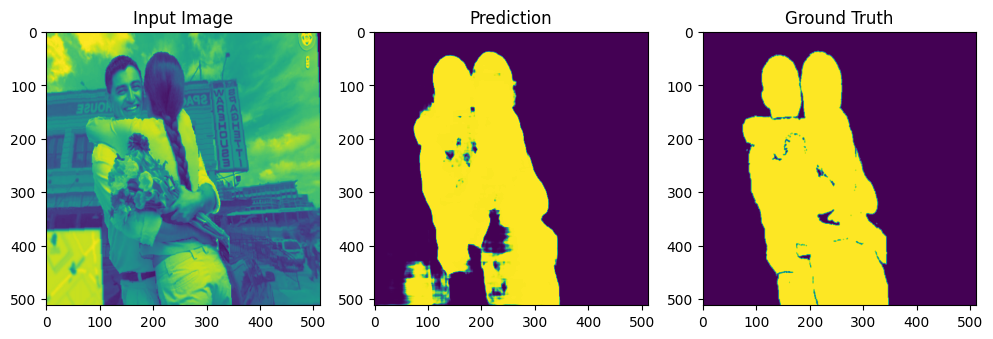

Epoch 18
=--------------------------------=
Train Loss: 0.6254861857209887, Validation Loss: 0.6321414033571879
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

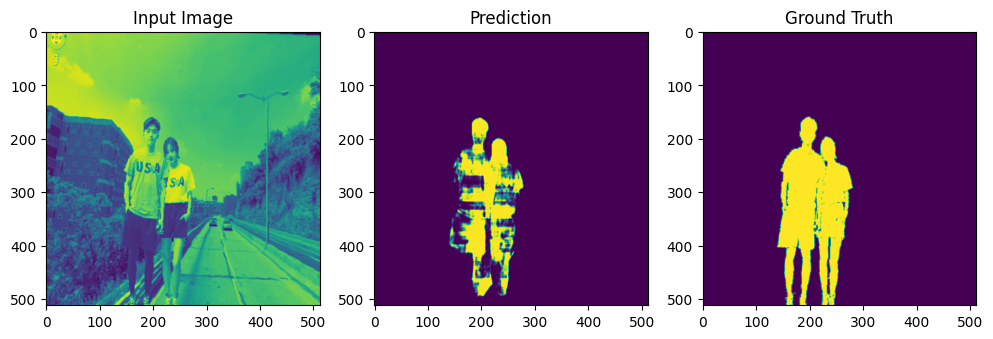

Epoch 19
=--------------------------------=
Train Loss: 0.6274931767157146, Validation Loss: 0.63376078804334
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.6319201707839965 -> 0.6294208337863286


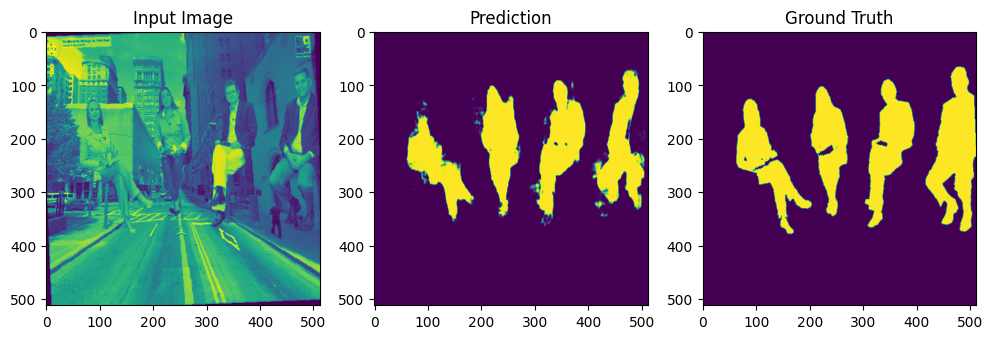

Epoch 20
=--------------------------------=
Train Loss: 0.6268618664571217, Validation Loss: 0.6294208337863286
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

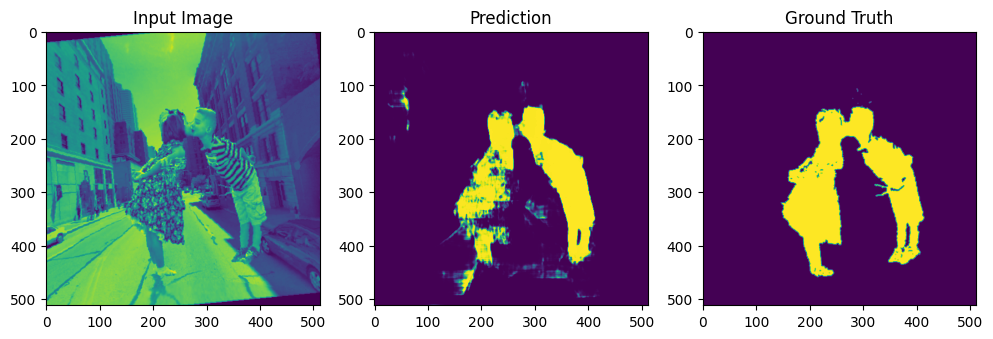

Epoch 21
=--------------------------------=
Train Loss: 0.6249035064663205, Validation Loss: 0.6390582114458084
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.6294208337863286 -> 0.6290450870990754


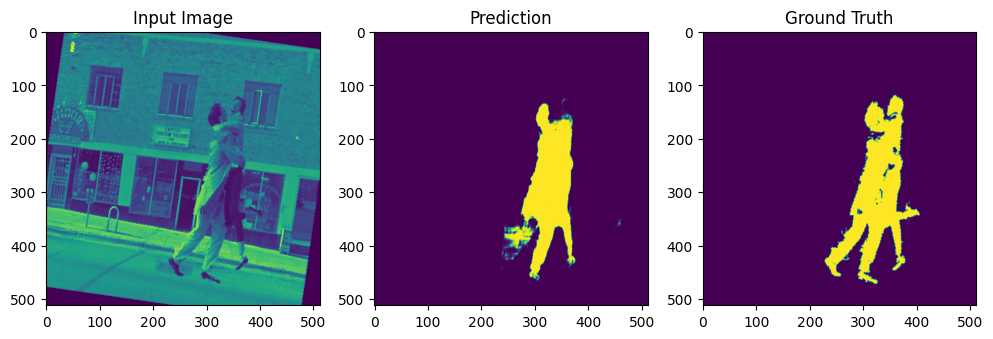

Epoch 22
=--------------------------------=
Train Loss: 0.6247433819941112, Validation Loss: 0.6290450870990754
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.6290450870990754 -> 0.6254947543144226


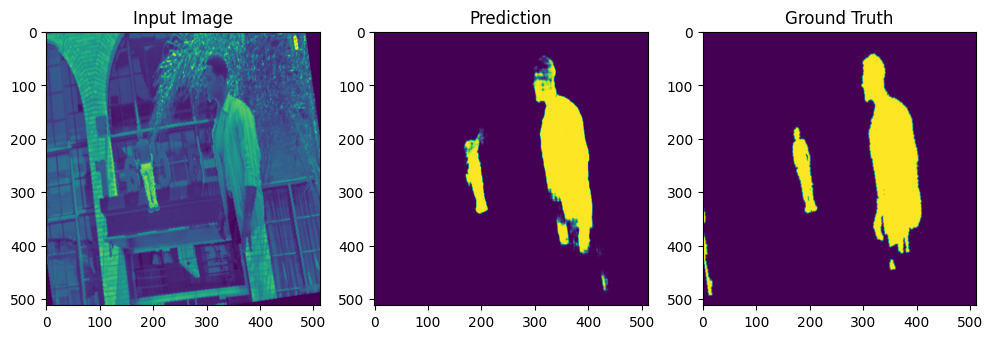

Epoch 23
=--------------------------------=
Train Loss: 0.6221854950700487, Validation Loss: 0.6254947543144226
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

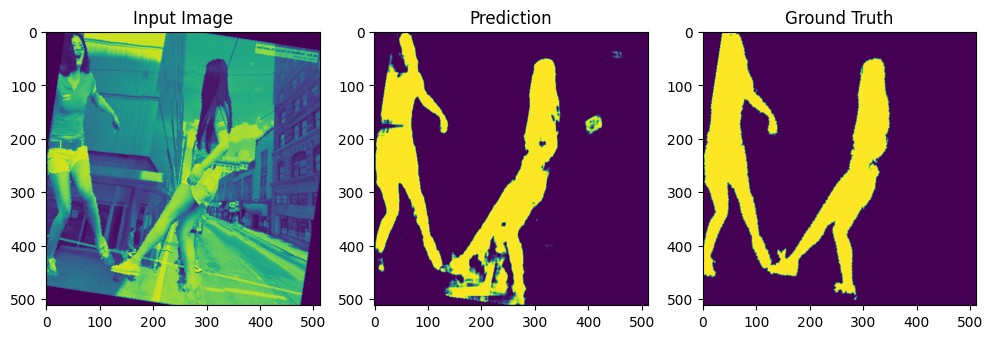

Epoch 24
=--------------------------------=
Train Loss: 0.6225515812635422, Validation Loss: 0.6283027271429698
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

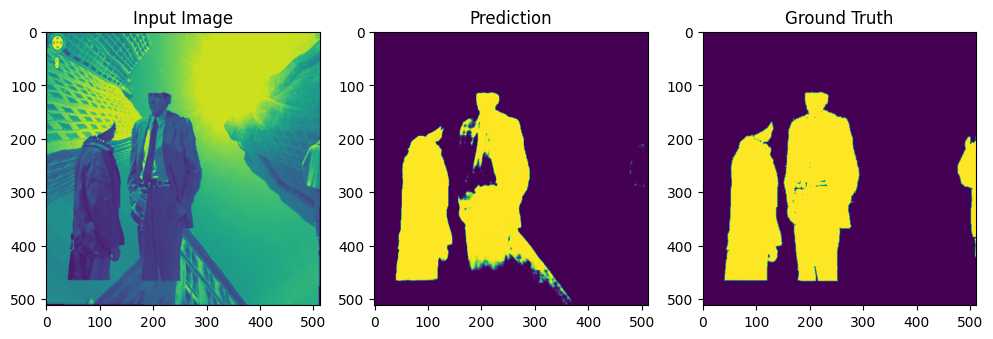

Epoch 25
=--------------------------------=
Train Loss: 0.621552984203611, Validation Loss: 0.6317066967487335
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

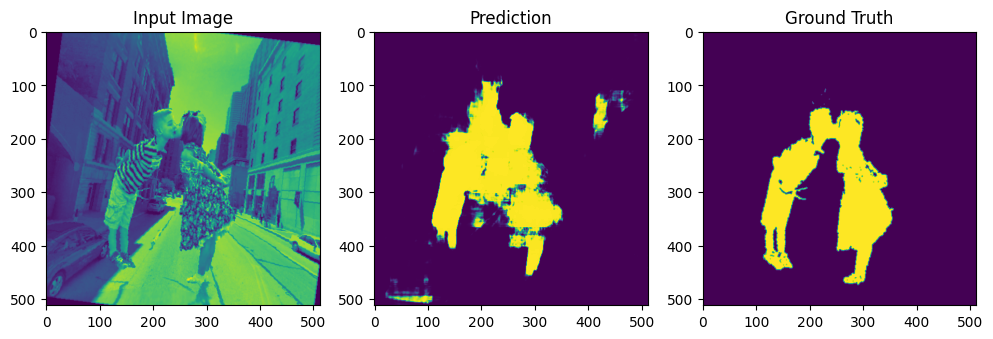

Epoch 26
=--------------------------------=
Train Loss: 0.62160524725914, Validation Loss: 0.6282932301362355
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.6254947543144226 -> 0.6237943341334661


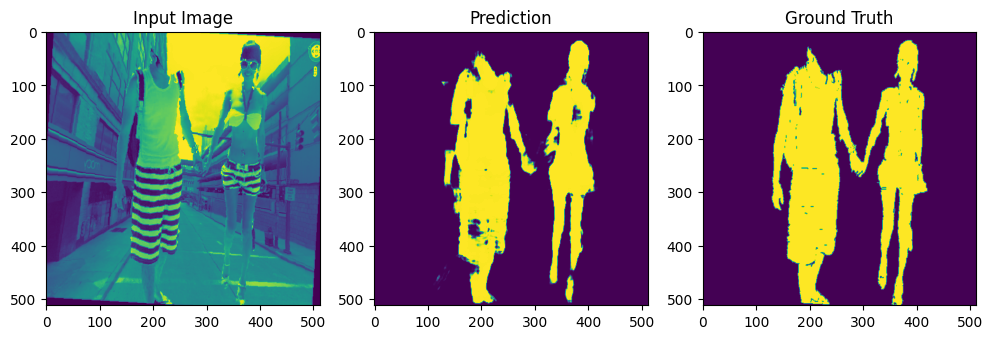

Epoch 27
=--------------------------------=
Train Loss: 0.6187071719339916, Validation Loss: 0.6237943341334661
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

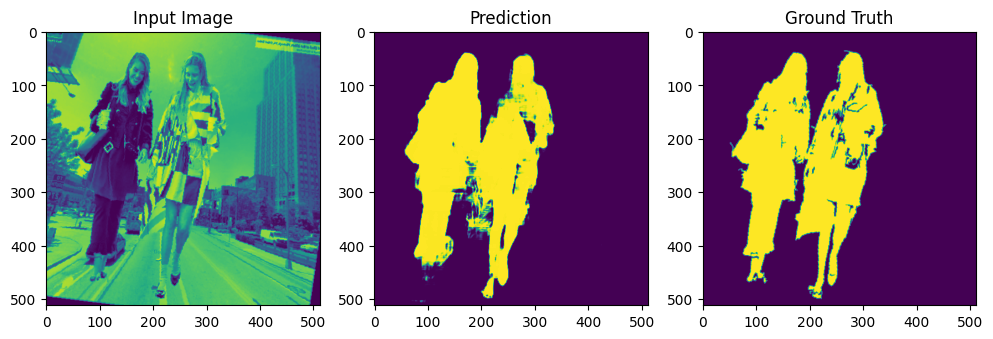

Epoch 28
=--------------------------------=
Train Loss: 0.618024765593665, Validation Loss: 0.6251564969619116
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

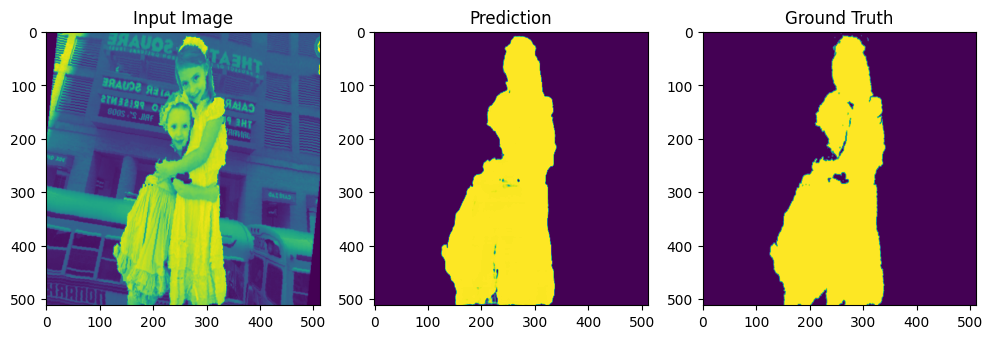

Epoch 29
=--------------------------------=
Train Loss: 0.6181536389248712, Validation Loss: 0.6238202939430872
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

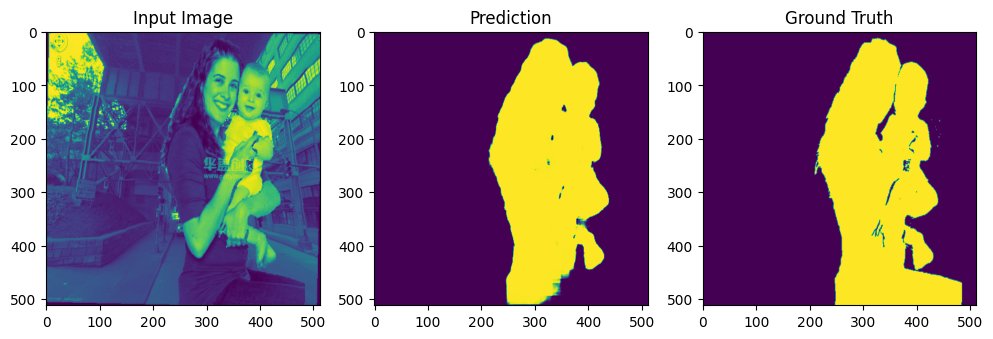

Epoch 30
=--------------------------------=
Train Loss: 0.6188282196010862, Validation Loss: 0.6265740046898524
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

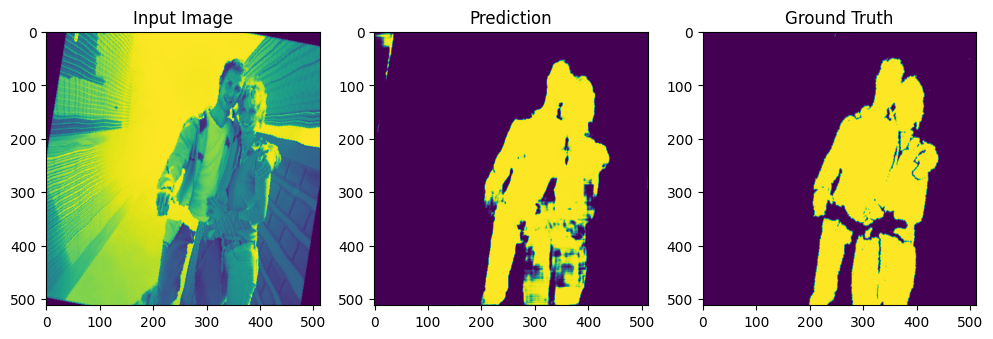

Epoch 31
=--------------------------------=
Train Loss: 0.6175821312836238, Validation Loss: 0.624569121003151
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/60 [00:00<?, ?it/s]

Lowest Validation Loss ReNewed! 0.6237943341334661 -> 0.6217102924982707


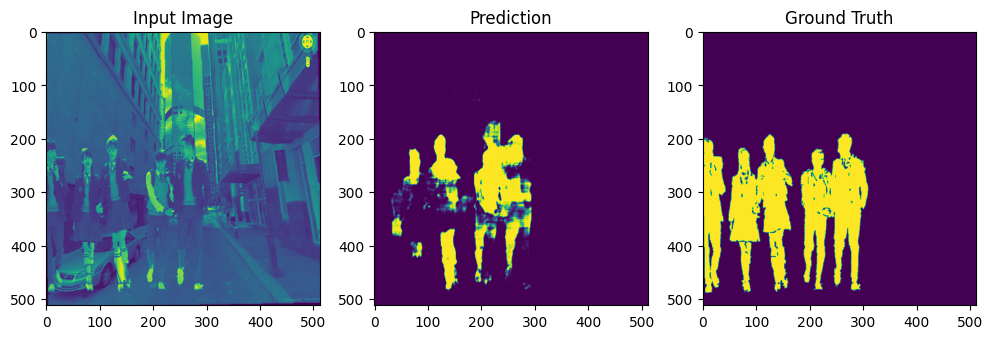

Epoch 32
=--------------------------------=
Train Loss: 0.6164718138320106, Validation Loss: 0.6217102924982707
=--------------------------------=


Training...:   0%|          | 0/140 [00:00<?, ?it/s]

In [ ]:
best_score = np.inf
train_loss, valid_loss = list(), list()
for epoch in range(EPOCH):
    model.train()
    running_loss = 0
    for image, mask in tqdm(train_loader, desc = 'Training...'):
        image = image.to(device)
        mask = mask.to(device)
        
        output = model(image)
        
        loss = criterion(output, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))
    
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for image, mask in tqdm(valid_loader, desc = 'Validating...'):
            image = image.to(device)
            mask = mask.to(device)
            
            output = model(image)
            
            loss = criterion(output, mask)
            running_loss += loss.item()
        valid_loss.append(running_loss / len(valid_loader))
        if best_score > valid_loss[-1]:
            print(f'Lowest Validation Loss ReNewed! {best_score} -> {valid_loss[-1]}')
            best_score = valid_loss[-1]
            torch.save(model.state_dict(), f'./models/UNet/Epoch_{epoch}_best_model.pth')
        
        plt.figure(figsize = (12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow((image[0].cpu().detach().numpy().reshape(AIM_RES, AIM_RES, -1) * 255).astype(np.uint8))
        plt.title('Input Image')
        plt.subplot(1, 3, 2)
        plt.imshow((output[0].cpu().detach().numpy().reshape(AIM_RES, AIM_RES, -1) * 255).astype(np.uint8))
        plt.title('Prediction')
        plt.subplot(1, 3, 3)
        plt.imshow((mask[0].cpu().detach().numpy().reshape(AIM_RES, AIM_RES, -1) * 255).astype(np.uint8))
        plt.title('Ground Truth')
        plt.show()
        
    print(f'Epoch {epoch}\n=--------------------------------=\nTrain Loss: {train_loss[-1]}, Validation Loss: {valid_loss[-1]}\n=--------------------------------=')

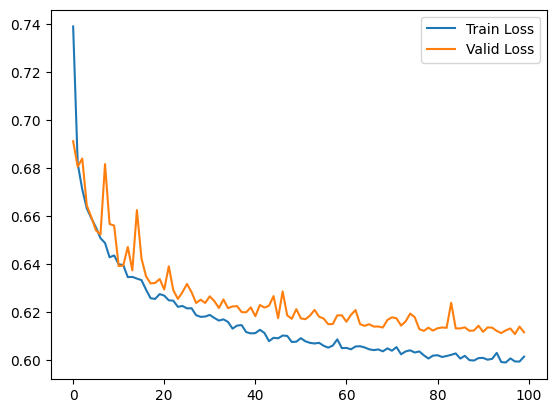

In [15]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['Train Loss', 'Valid Loss'])
plt.show()
